In [61]:
using Pkg

In [62]:
using Flux
using Flux: onehot, chunk, batchseq, throttle, crossentropy
using StatsBase: wsample
using Base.Iterators: partition
using CSV
using MultivariateStats
using LinearAlgebra
using StatsBase

In [63]:
# BIN_STEP = .0001;
N_FEATURES = 1;
ALPHABET_SIZE = 200;

In [64]:
add_dim(x::Array,dim) = reshape(x, (size(x)...,1))

add_dim (generic function with 1 method)

In [65]:
prctile(x::Array,p) = sort(x)[Int(round((p/100)*length(x)))]

prctile (generic function with 1 method)

In [66]:
text = CSV.read("processed_data.csv", header=0);
text = convert(Array, text);
timepts = text[:,1];
heel_strike = [findall(text[:,8].==1), findall(text[:,end-1].==1)];
startPF = [findall(text[:,8].==2), findall(text[:,end-1].==2)];
PFend = [findall(text[:,8].==3), findall(text[:,end-1].==3)];
labels = text[:,end];
data = text[:,[2,3,4,5,6,7,9,10,11,12,13,14]];

data0 = reshape(data,(size(data,1)*2,6))

heel_strike = vcat(heel_strike[1],heel_strike[2].+length(timepts))
startPF = vcat(startPF[1], startPF[2].+length(timepts))
PFend = vcat(PFend[1], PFend[2].+length(timepts))

SOS = 1.1;
EOS = 99.9;

mins = [minimum(data0[:,col]) for col in range(1,size(data0,2))];
maxs_data = [maximum(data0[:,col]) for col in range(1,size(data0,2))];
mins = reshape(mins,(1,6));
data = data0 .-mins;
data0 = data0 ./ reshape(maxs_data, (1,6));

In [67]:
# function customPCA(dat, num_components)
#     mins_data = [minimum(data[:,col]) for col in range(1,size(data,2))];
#     maxs_data = [maximum(data[:,col]) for col in range(1,size(data,2))];
#     dat = dat .- reshape(mins_data,(1,6));
#     dat = dat ./ reshape(maxs_data, (1,6));
#     V = StatsBase.cov(dat);
#     values = eigvals(V)
#     vectors = eigvecs(V)
    
#     k = sortperm(values,rev=true)
#     k_keep = k[1:num_components]
#     data_proj = transpose(vectors[:,k_keep])*transpose(dat)
#     return values, vectors, data_proj, k_keep
# end

In [68]:
# Try PCA
M = fit(PCA, transpose(data0), maxoutdim = 1);
projMat = projection(M);
component1 = data0*projMat;
println(component1[1:10])
println(principalvars(M))
comp_data = MultivariateStats.transform(M, transpose(data0));
println(comp_data[1:10])
println(size(MultivariateStats.reconstruct(M,comp_data)))

[0.609633, 0.563788, 0.628653, 0.650854, 0.582618, 0.591259, 0.60114, 0.567367, 0.557962, 0.55725]
[0.170558]
[0.389138, 0.343294, 0.408159, 0.43036, 0.362124, 0.370764, 0.380645, 0.346872, 0.337468, 0.336756]
(6, 21218)


In [69]:
data = component1;
mins_f = minimum(data)
BIN_STEP = (maximum(data) - minimum(data))./ALPHABET_SIZE
data = (round.((data .- mins_f)./BIN_STEP)) .+ 1;

st_idx = 1;
seqlens = [];
data_old = Array{Float64}(undef, 0, N_FEATURES)
data_stride = [];
alphabet = unique(data);
append!(alphabet, [SOS EOS])
data_a = map(ch -> onehot(ch, alphabet), data);
stop_idx = onehot(SOS, alphabet);

for i in 1:length(startPF)
    global data_n
    data_n = data[st_idx:startPF[i],:]
    
    data_n=vcat(data_n, reshape(repeat([SOS],(N_FEATURES)),(1,N_FEATURES)))
    data_n = vcat(data_n, data[startPF[i]+1:PFend[i],:])
    data_n=vcat(data_n, reshape(repeat([EOS],(N_FEATURES)),(1,N_FEATURES)))
    data_n = [data_old; data_n]
    data_old = copy(data_n)
    st_idx = PFend[i] +1
    if i > 1
        data_add = data_n[startPF[i-1]:startPF[i],:];
        data_add = map(ch -> onehot(ch, alphabet), data_add);
        append!(seqlens, length(startPF[i-1]:startPF[i]))
        append!(data_stride, [data_add])
    end
end

In [70]:
N = length(alphabet);
seqlen = prctile(seqlens,75);
nbatch = 50;

Xs0 = collect(partition(batchseq(chunk(reshape(data_a[:,1],(1,length(data_a[:,1]))), nbatch), stop_idx), seqlen));
Ys0 = collect(partition(batchseq(chunk(reshape(data_a[2:end,1],(1,length(data_a[2:end,1]))), nbatch), stop_idx), seqlen));

In [71]:
using Flux: @epochs

m = Chain(
#   Conv((3,1), 6=>1, relu),
#   x -> maxpool(x, (3,1)),
  LSTM(N, 128),
  LSTM(128, 128),
  Dense(128, N),
  softmax)

m = gpu(m)

function loss(xs, ys)
  l = sum(crossentropy.(m.(gpu.(xs)), gpu.(ys)))
  Flux.truncate!(m)
  return l
end

opt = ADAM(params(m), 0.01)
tx, ty = (gpu.(Xs0[3]), gpu.(Ys0[3]))
evalcb = () -> @show loss(tx, ty)

@epochs 100 Flux.train!(loss, zip(Xs0, Ys0), opt,
            cb = throttle(evalcb, 2))

# Sampling
m = cpu(m)

┌ Info: Epoch 1
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 440.35350994657955 (tracked)


┌ Info: Epoch 2
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 414.5368938803978 (tracked)


┌ Info: Epoch 3
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 421.45401818971897 (tracked)


┌ Info: Epoch 4
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 416.15036511546697 (tracked)


┌ Info: Epoch 5
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 412.79567928064824 (tracked)


┌ Info: Epoch 6
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 411.0950780266293 (tracked)


┌ Info: Epoch 7
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 410.60028420335317 (tracked)


┌ Info: Epoch 8
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 410.647476348861 (tracked)


┌ Info: Epoch 9
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 410.0000546726833 (tracked)


┌ Info: Epoch 10
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 408.7461648862076 (tracked)


┌ Info: Epoch 11
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 407.6777175583105 (tracked)


┌ Info: Epoch 12
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 404.79405334095037 (tracked)


┌ Info: Epoch 13
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 395.77827232156517 (tracked)


┌ Info: Epoch 14
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 390.2963242311801 (tracked)


┌ Info: Epoch 15
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 381.8990786684471 (tracked)


┌ Info: Epoch 16
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 376.3949403610595 (tracked)


┌ Info: Epoch 17
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 367.3509606122639 (tracked)


┌ Info: Epoch 18
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 363.2959516165889 (tracked)


┌ Info: Epoch 19
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 356.8379296284123 (tracked)


┌ Info: Epoch 20
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 351.1479761060787 (tracked)


┌ Info: Epoch 21
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 343.3126073124348 (tracked)


┌ Info: Epoch 22
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 336.44069840079953 (tracked)


┌ Info: Epoch 23
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 328.54061345116924 (tracked)


┌ Info: Epoch 24
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 317.9674289767705 (tracked)


┌ Info: Epoch 25
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 308.7143211100312 (tracked)


┌ Info: Epoch 26
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 299.71892245529125 (tracked)


┌ Info: Epoch 27
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 292.2343119291055 (tracked)


┌ Info: Epoch 28
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 284.2031521040831 (tracked)


┌ Info: Epoch 29
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 278.53177300576823 (tracked)


┌ Info: Epoch 30
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 272.6559985365905 (tracked)


┌ Info: Epoch 31
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 272.27177907480905 (tracked)


┌ Info: Epoch 32
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 278.13762537786613 (tracked)


┌ Info: Epoch 33
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 263.9316727811658 (tracked)


┌ Info: Epoch 34
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 261.41483686672575 (tracked)


┌ Info: Epoch 35
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 256.1864920190435 (tracked)


┌ Info: Epoch 36
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 252.03000071854524 (tracked)


┌ Info: Epoch 37
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 250.44524474548945 (tracked)


┌ Info: Epoch 38
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 251.94001999588605 (tracked)


┌ Info: Epoch 39
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 247.97597706854756 (tracked)


┌ Info: Epoch 40
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 242.2969096923574 (tracked)


┌ Info: Epoch 41
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 236.9232428772357 (tracked)


┌ Info: Epoch 42
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 233.92521915032142 (tracked)


┌ Info: Epoch 43
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 231.33315368602 (tracked)


┌ Info: Epoch 44
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 227.26917339782415 (tracked)


┌ Info: Epoch 45
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 223.85518005652057 (tracked)


┌ Info: Epoch 46
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 220.39051843084823 (tracked)


┌ Info: Epoch 47
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 217.375852994516 (tracked)


┌ Info: Epoch 48
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 214.84244237005748 (tracked)


┌ Info: Epoch 49
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 212.7537958802511 (tracked)


┌ Info: Epoch 50
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 210.75744103376195 (tracked)


┌ Info: Epoch 51
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 209.85297432455394 (tracked)


┌ Info: Epoch 52
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 206.59426203097797 (tracked)


┌ Info: Epoch 53
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 204.66291423573463 (tracked)


┌ Info: Epoch 54
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 203.19086936594815 (tracked)


┌ Info: Epoch 55
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 200.6479155447433 (tracked)


┌ Info: Epoch 56
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 198.39096154269518 (tracked)


┌ Info: Epoch 57
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 197.36924923762857 (tracked)


┌ Info: Epoch 58
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 194.36959983506614 (tracked)


┌ Info: Epoch 59
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 193.05035797482128 (tracked)


┌ Info: Epoch 60
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 191.53524628566092 (tracked)


┌ Info: Epoch 61
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 189.58042331876956 (tracked)


┌ Info: Epoch 62
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 187.73664678924789 (tracked)


┌ Info: Epoch 63
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 188.05910748814014 (tracked)


┌ Info: Epoch 64
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 186.20338601598905 (tracked)


┌ Info: Epoch 65
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 183.9114252549501 (tracked)


┌ Info: Epoch 66
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 185.50388108485242 (tracked)


┌ Info: Epoch 67
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 182.92191215653196 (tracked)


┌ Info: Epoch 68
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 182.15441387201327 (tracked)


┌ Info: Epoch 69
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 179.8915011356034 (tracked)


┌ Info: Epoch 70
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 178.36109784534716 (tracked)


┌ Info: Epoch 71
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 176.98277813247648 (tracked)


┌ Info: Epoch 72
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 175.87043908642687 (tracked)


┌ Info: Epoch 73
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 173.89512490576683 (tracked)


┌ Info: Epoch 74
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 173.1415458179497 (tracked)


┌ Info: Epoch 75
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 172.03588863679164 (tracked)


┌ Info: Epoch 76
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 170.94718207972585 (tracked)


┌ Info: Epoch 77
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 169.33594871312746 (tracked)


┌ Info: Epoch 78
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 168.73471819943737 (tracked)


┌ Info: Epoch 79
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 167.96625586015233 (tracked)


┌ Info: Epoch 80
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 167.10472820492498 (tracked)


┌ Info: Epoch 81
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 168.68693604824327 (tracked)


┌ Info: Epoch 82
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 167.74694405371102 (tracked)


┌ Info: Epoch 83
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 165.58626020234257 (tracked)


┌ Info: Epoch 84
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 165.90992996574107 (tracked)


┌ Info: Epoch 85
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 166.51767334131156 (tracked)


┌ Info: Epoch 86
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 162.81096526316233 (tracked)


┌ Info: Epoch 87
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 163.0728850646373 (tracked)


┌ Info: Epoch 88
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 161.56853215989048 (tracked)


┌ Info: Epoch 89
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 159.5064579552855 (tracked)


┌ Info: Epoch 90
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 159.84555560630787 (tracked)


┌ Info: Epoch 91
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 158.12434966674337 (tracked)


┌ Info: Epoch 92
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 158.36102292361014 (tracked)


┌ Info: Epoch 93
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 156.78142868930405 (tracked)


┌ Info: Epoch 94
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 156.17973845438615 (tracked)


┌ Info: Epoch 95
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 155.3162757698416 (tracked)


┌ Info: Epoch 96
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 154.46303501975615 (tracked)


┌ Info: Epoch 97
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 153.8792015822059 (tracked)


┌ Info: Epoch 98
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 153.45558905470693 (tracked)


┌ Info: Epoch 99
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 151.8839684476006 (tracked)


┌ Info: Epoch 100
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(tx, ty) = 151.95425243835956 (tracked)


Chain(Recur(LSTMCell(187, 128)), Recur(LSTMCell(128, 128)), Dense(128, 187), NNlib.softmax)

In [75]:
function sample(m, alphabet, len; temp = 1)
  Flux.reset!(m)
  buf = []
  c = rand(alphabet)
  for i = 1:len
    append!(buf,c)
    c = wsample(alphabet, m(onehot(c, alphabet)).data)
  end
  return buf
end

buffer = sample(m, alphabet, 1000)
xmat = reconstruct(M, convert(Array{Float64},reshape(buffer,(1,length(buffer)))))

6×1000 Array{Float64,2}:
  -9.62952  -10.754    -10.8789   …  -12.0034   -11.7535   -11.5037 
  -9.00739  -10.0635   -10.1808      -11.2369   -11.0022   -10.7675 
 -25.6898   -28.7307   -29.0685      -32.1093   -31.4336   -30.7579 
 -44.3565   -49.5699   -50.1492      -55.3625   -54.204    -53.0455 
  -2.22541   -2.48242   -2.51098      -2.76799   -2.71088   -2.65376
  54.803     61.2937    62.0148   …   68.5055    67.0631    65.6208 

In [76]:
using Plots

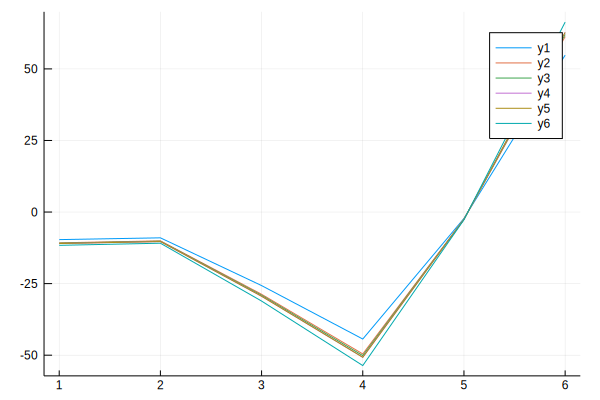

In [77]:
plot(xmat[:,1])
plot!(xmat[:,2])
plot!(xmat[:,3])
plot!(xmat[:,4])
plot!(xmat[:,5])
plot!(xmat[:,6])